# 조건부 라우팅 적용 : 감정 분석 챗봇
Conditional Routing

In [1]:
# 사용자가 작성한 메시지의 감정 상태가 어떤지 파악해서 답변을 다르게 하는 예제를 작성. 
# 그래프의 흐름: '시작 노드 → 감정 파악 → 부정 답변 | 중립 답변 |긍정 답변 → 종료 노드' .


# import

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Dict, Any, Literal
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import random
from IPython.display import Image, display

# 상태 정의

In [4]:
class EmotionBotState(BaseModel):
    user_message: str = Field(default='', description="사용자 입력 메세지")
    emotion: str = Field(default='', description="분석된 감정")
    response: str = Field(default='', description="최종 응답 메세지")

# LLM 모델 초기화

In [5]:
# ② LangChain LLM 초기화 - 감정 분석에 사용할 AI 모델 설정
# 감정 분류는 단일 단어만 필요하므로 max_tokens를 10으로 주어서 토큰 수를 제한
llm = ChatOpenAI(model='gpt-4o', max_tokens=10)

# 노드 : LLM기반 감정분석

In [6]:
def analyze_emotion(state: EmotionBotState) -> Dict[str, Any]:
    message = state.user_message
    print(f'🟦 LLM 감석분석중: "{message}"')

    messages = [
        SystemMessage(
            content="당신은 감정 분석 전문가입니다. 사용자의 메시지를 분석하여 'positive', 'negative', 'neutral' 중 하나로 감정을 분류해주세요. 답변은 반드시 하나의 단어만 출력하세요."
        ),
        HumanMessage(content=f"다음 메시지의 감정을 분석해주세요: '{message}'"),
    ]

    response = llm.invoke(messages)
    emotion = response.content.strip().lower()
    print(f'\t✅ 모델 응답: {emotion}') 

    # 유효성 검사
    if emotion not in ["positive", 'negative', 'neutral']:
        emotion = 'neutral'

    print(f'\tLLM 감정 분석 결과: {emotion}')

    return {'emotion': emotion}
    # 노드에서 리턴하는 값으로 상태를 업데이트
    
    # 위 값에 따라 조건부 라우팅을 하게 할것이다.

# 조건부 라우팅 함수
- 입력: 상태
- 출력: 다음에 실행할 '노드의 이름(str)'

In [8]:
def route_by_emotion(state: EmotionBotState
                         # typehint 의 Literal 은 '값 그 자체' 로 제한할때 사용.
                    ) -> Literal["positive_response", "negative_response", "neutral_response"]:
    emotion = state.emotion
    print(f'🟦 라우팅: {emotion}')

    if emotion == 'positive':
        return 'positive_response'
    elif emotion == 'negative':
        return 'negative_response'
    else:
        return 'neutral_response'
    

# 응답 생성 노드(들)

In [9]:
# 긍정적 응답 생성
def generate_positive_response(state: EmotionBotState) -> Dict[str, Any]:
    responses = ["정말 좋은 소식이네요!", "기분이 좋으시군요!", "멋지네요!"]
    return {"response": random.choice(responses)}


# 부정적 응답 생성
def generate_negative_response(state: EmotionBotState) -> Dict[str, Any]:
    responses = [
        "힘든 시간이시군요. 괜찮아요.",
        "마음이 아프시겠어요.",
        "더 좋은 날이 올 거예요.",
    ]
    return {"response": random.choice(responses)}


# 중립적 응답 생성
def generate_neutral_response(state: EmotionBotState) -> Dict[str, Any]:
    responses = [
        "감사해요! 더 자세히 말씀해주세요.",
        "이해했어요. 다른 도움이 필요하시면 말씀하세요!",
        "흥미로운 주제네요!",
    ]
    return {"response": random.choice(responses)}

# 그래프 정의

In [11]:
def create_emotion_bot_graph():
    workflow = StateGraph(EmotionBotState)

    # 노드 추가
    workflow.add_node('analyze_emotion', analyze_emotion)
    workflow.add_node("positive_response", generate_positive_response)
    workflow.add_node("negative_response", generate_negative_response)
    workflow.add_node("neutral_response", generate_neutral_response)    

    # 시작 설정
    workflow.add_edge(START, "analyze_emotion")

    # 조건부 엣지 설정 - 조건부 라우팅(동적 라우팅) 구현
    #  : add_conditional_edges()는 LangGraph의 핵심 기능으로, 
    #   출발 노드 이름, 라우팅 함수, 가능한 목적지 매핑의 세 가지 인자를 받습니다. 
    #   이를 통해 런타임에 상태 기반으로 다음 실행 경로를 동적으로 결정할 수 있습니다.    
    workflow.add_conditional_edges(
        "analyze_emotion",  # 출발 노드 이름
        route_by_emotion,   # 라우팅 함수
        {   
            # 라우팅 함수 결과 -> 분기 목적지 노드 매핑
            "positive_response": "positive_response",
            "negative_response": "negative_response",
            "neutral_response": "neutral_response",
        }
    )

    # 종료 설정
    workflow.add_edge("positive_response", END)
    workflow.add_edge("negative_response", END)
    workflow.add_edge("neutral_response", END)

    return workflow.compile()

# 그래프 생성 & 실행

In [12]:
app = create_emotion_bot_graph()

In [13]:
test_cases = [
    "오늘 정말 기분이 좋아요!",
    "너무 슬프고 힘들어요...",
    "날씨가 어떤가요?",
]

In [16]:
for i, message in enumerate(test_cases, 1):
    print(f'테스트 {i}: "{message}"')
    # 초기 상태값 생
    state = EmotionBotState(user_message=message)
    result = app.invoke(state)
    print(f'응답: {result['response']}')
    print('-' * 20)

테스트 1: "오늘 정말 기분이 좋아요!"
🟦 LLM 감석분석중: "오늘 정말 기분이 좋아요!"
	✅ 모델 응답: positive
	LLM 감정 분석 결과: positive
🟦 라우팅: positive
응답: 기분이 좋으시군요!
--------------------
테스트 2: "너무 슬프고 힘들어요..."
🟦 LLM 감석분석중: "너무 슬프고 힘들어요..."
	✅ 모델 응답: negative
	LLM 감정 분석 결과: negative
🟦 라우팅: negative
응답: 마음이 아프시겠어요.
--------------------
테스트 3: "날씨가 어떤가요?"
🟦 LLM 감석분석중: "날씨가 어떤가요?"
	✅ 모델 응답: neutral
	LLM 감정 분석 결과: neutral
🟦 라우팅: neutral
응답: 감사해요! 더 자세히 말씀해주세요.
--------------------


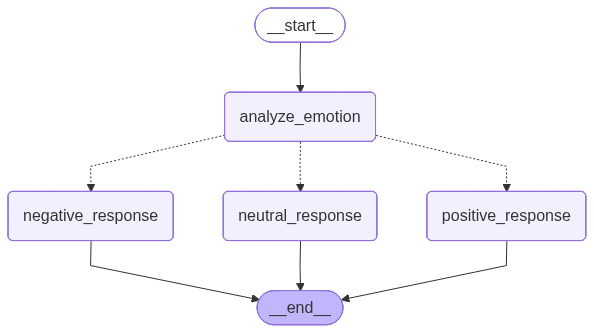

In [17]:
Image(app.get_graph().draw_mermaid_png())